### Imports

In [1]:
import pandas as pd
import datetime
import os
import sys
import math
import matplotlib.pyplot as plt
import numpy as np
import warnings
from pandas.errors import SettingWithCopyWarning


warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

### Parameters

In [2]:
buy_threshold = 1.06
sell_threshold = 1.04
starting_balance = 1000000
price_cap_lower = 0
ttm_cap_lower = 0

run_optimizing = False
google_colab = False
preparing_file = False
write_file = False

### Data loading

In [3]:
if google_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install -U -q PyDrive
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials
    # Authenticate and create the PyDrive client.
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    id = "111QpHwxMy28NV8I23Bj_ZD1H32H6n7bV"
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile('11.05 1 mnd test sett full model run.csv')  
    df = pd.read_csv('11.05 1 mnd test sett full model run.csv')
else:
    # Set the path to the root directory
    path = os.path.abspath(os.path.join(os.getcwd(), '../..'))
    # Read dataframes using Dask
    df = pd.read_csv(path + '/data/predictions/11.05 1 mnd test sett full model run_with_TTM0_Q1and2_2018_filtered_missing.csv')

### Data processing

In [4]:
# Only keep 5% of the OptionID groups at random
#df = df.groupby('Option_ID').apply(lambda x: x.sample(frac=0.05, random_state=1))

In [5]:
print(len(df))

395030


In [6]:
if preparing_file:
        # Dates
        df['Expiry_date'] = pd.to_datetime(df['Quote_date']) + pd.to_timedelta(df['TTM'] * 365, unit='D')
        df['Quote_date'] = pd.to_datetime(df['Quote_date']).dt.date 
        df['Expiry_date'] = pd.to_datetime(df['Expiry_date']).dt.date 

        # Adding option ID
        df["Option_ID"] = df["Expiry_date"].astype(str) + "-" + df["Strike"].astype(str)

        df_original = df[(df["Quote_date"] >= pd.to_datetime("2018-01-01").date()) & 
                        (df["Quote_date"] <= pd.to_datetime("2019-01-01").date())]

        df = df[(df["Expiry_date"] >= pd.to_datetime("2018-01-01").date()) & 
                (df["Expiry_date"] <= pd.to_datetime("2018-12-31").date())]

        df = df[(df["Quote_date"] >= pd.to_datetime("2018-01-01").date()) & 
                (df["Quote_date"] <= pd.to_datetime("2018-12-31").date())]


Adding TTM=0 row

In [7]:
if preparing_file:    
    # Sort the dataframe by Quote_date and Expiry_date
    df = df.sort_values(['Quote_date', 'Expiry_date'])

    groups = df.groupby(['Expiry_date', 'Strike'])

    for _, group in groups:

        # Sort group so that the last row is the one with the lowest TTM
        group = group.sort_values('TTM', ascending=False)

        # Taking row from option group (could be any) to be used in getting the Strike price
        last_row = group.iloc[-1]
        
        expiry_date = last_row['Expiry_date']
        # Get the underlying price on the day of expiry

        if expiry_date not in df_original['Quote_date'].values:
            print("Expiry date not in df_original: ", expiry_date)
            print("Weekday: ", expiry_date.weekday())
            # Delete group from df
            df = df.drop(group.index)
            continue

        underlying_last_on_expiry = df_original.loc[df_original['Quote_date'] == expiry_date, 'Underlying_last'].iloc[0]
        # Calculate the intrinsic value
        intrinsic_value = np.maximum(underlying_last_on_expiry - last_row['Strike'], 0)

        new_row = last_row.copy()
        new_row['Quote_date'] = expiry_date
        new_row['Expiry_date'] = expiry_date
        new_row['TTM'] = 0
        new_row['Underlying_last'] = underlying_last_on_expiry
        new_row['Price'] = intrinsic_value

        df = df.append(new_row, ignore_index=True)

    # Sort the dataframe by Quote_date and Expiry_date
    df = df.sort_values(['Quote_date', 'Expiry_date'])

In [8]:
print(len(df))

395030


### Make sure prices are available every day for an option group

In [9]:
if preparing_file:
    unique_dates = df['Quote_date'].unique()

    option_groups = df.groupby(['Option_ID'])

    # Remove option groups if it has a date between it's first and last that is not in unique_dates
    for option_id, option_group in option_groups:
        group_first_date = option_group['Quote_date'].iloc[0]
        group_last_date = option_group['Quote_date'].iloc[-1]

        if group_first_date not in unique_dates or group_last_date not in unique_dates:
            df = df.drop(option_group.index)
            print("Dropped option group: ", option_id, " because it's first or last date is not in unique_dates")

        # If every unique_dates between group_first_date and group_last_date is not in group, drop the group
        dates_between = unique_dates[(unique_dates >= group_first_date) & (unique_dates <= group_last_date)]
        if len(dates_between) != len(option_group['Quote_date'].unique()):
            df = df.drop(option_group.index)
            print("Dropped option group: ", option_id, " because it's missing dates between it's first and last date")


        if len(option_group) < 2:
            df = df.drop(option_group.index)
            print("Dropped option group: ", option_id, " because it has less than 2 rows")


In [10]:
# Write df to file
if write_file:
    df.to_csv(path + '/data/predictions/11.05 1 mnd test sett full model run_with_TTM0_Q1and2_2018_filtered_missing.csv', index=False)

### Functions

In [11]:
def generate_buy_sell_signals(df, buy_threshold, sell_threshold):
    buy_signal = (df['Prediction'] / df['Price']) >= buy_threshold
    sell_signal = (df['Price'] / df['Prediction']) >= sell_threshold
    return buy_signal, sell_signal


def trader(df, buy_signal, sell_signal, starting_balance, price_cap_lower, ttm_cap_lower):
    # Filter out options that expire before the last quote date
    # Timestamps are converted to dates
    df['Expiry_date'] = pd.to_datetime(df['Expiry_date']).dt.date
    df['Quote_date'] = pd.to_datetime(df['Quote_date']).dt.date
    df = df[df['Expiry_date'] <= df['Quote_date'].max()]
    df = df[df["TTM"] >= ttm_cap_lower]
    
    df['Signal'] = 0
    df.loc[buy_signal, 'Signal'] = 1
    df.loc[sell_signal, 'Signal'] = -1

    df['Position_this_opt'] = 0
    df['Balance'] = starting_balance
    df['Profit'] = 0

    df = df.sort_values('Quote_date')
    df['Option_ID'] = df['Option_ID'].astype(str)

    position_dict = {id:0 for id in df['Option_ID'].unique()}
    balance_dict = {date:starting_balance for date in df['Quote_date'].unique()}

    def operation(row):
        if row['Price'] < price_cap_lower:
            return row

        balance = balance_dict[row['Quote_date']]
        position = position_dict[row['Option_ID']]

        if row['Signal'] == 1 and row["Quote_date"] != row["Expiry_date"] and balance >= row['Price']:
            balance -= row['Price']
            position += 1

        elif row['Signal'] == -1 and row["Quote_date"] != row["Expiry_date"] and balance > 0:
            balance += row['Price']
            position -= 1

        elif row["Quote_date"] == row["Expiry_date"] and position != 0:
            intrinsic_value = max(0, row['Underlying_last'] - row['Strike'])
            adjustment = intrinsic_value if position >= 1 else -intrinsic_value
            balance += adjustment * abs(position)
            position = 0

        row['Position_this_opt'] = position
        row['Balance'] = balance

        position_dict[row['Option_ID']] = position
        balance_dict[row['Quote_date']] = balance

        return row

    df = df.apply(operation, axis=1)
    df.loc[(df['Position_this_opt'] == 0), 'Balance'] = df['Quote_date'].map(balance_dict)

    return df



def calculate_options_value(df):
    df['Options_value'] = 0
    # Iterate over every Quote_date
    for date in df['Quote_date'].unique():
        # For every Quote date, multiply each row's Position_this_opt with the Price and sum it up.
        options_value_sum = (df.loc[df['Quote_date'] == date, 'Position_this_opt'] * df.loc[df['Quote_date'] == date, 'Price']).sum()
        # The result should be added to every row with the same Quote_date in the Options_value
        df.loc[df['Quote_date'] == date, 'Options_value'] = options_value_sum
    df['Total_value'] = df['Balance'] + df['Options_value']
    return df

### Run code

In [12]:
from pandas import to_datetime

def print_results(df, starting_balance):
    print("Starting balance", starting_balance)
    print("Ending balance", df['Balance'].iloc[-1])
    print("Number of trades", df['Signal'].abs().sum())
    profit = df['Balance'].iloc[-1] - starting_balance
    print("Profit", profit)
    print("Profit per trade", profit / df['Signal'].abs().sum())
    # Convert the 'Quote_date' column to datetime
    df['Quote_date'] = to_datetime(df['Quote_date'])
    print("Profit per day", profit / (df['Quote_date'].max() - df['Quote_date'].min()).days)
    num_days = (df['Quote_date'].max() - df['Quote_date'].min()).days
    print("Number of days", num_days)
    print("Sharpe ratio: ", sharpe_ratio2(df))


In [13]:
def sharpe_ratio(df):
    df = df.copy()
    # Group by Quote_date and keep the last row of each group
    df = df.groupby('Quote_date').last()
    # Calculate daily returns
    df['Daily_Returns'] = df['Total_value'].pct_change()
    # Convert the annual risk-free rate to a daily rate
    df['Daily_Rf'] = (1 + df['R'])**(1/252) - 1
    # Calculate the excess returns
    excess_returns = df['Daily_Returns'] - df['Daily_Rf']
    # Calculate sharpe ratio
    sharpe_ratio = np.sqrt(252) * (excess_returns.mean() / excess_returns.std())
    return sharpe_ratio

In [14]:
def sharpe_ratio2(df, rf=0.02):
    df = df.copy()

    # Calculate daily returns
    df['Daily_Returns'] = df['Total_value'].pct_change()

    starting_balance = df['Balance'].iloc[0]
    ending_balance = df['Balance'].iloc[-1]

    num_days = (df['Quote_date'].max() - df['Quote_date'].min()).days

    avg_daily_return = (ending_balance / starting_balance)**(1/num_days) - 1

    avg_daily_return_excess = avg_daily_return - rf / 252

    df["Excess_Returns"] = df["Daily_Returns"] - rf / 252

    std_daily_excess_return = df["Excess_Returns"].std()

    sharpe_ratio = np.sqrt(252) * (avg_daily_return_excess / std_daily_excess_return)

    return sharpe_ratio

In [15]:
if run_optimizing == False:
    df = df.copy()
    buy_signal, sell_signal = generate_buy_sell_signals(df, buy_threshold, sell_threshold)
    df = trader(df, buy_signal, sell_signal, starting_balance, price_cap_lower, ttm_cap_lower)
    df = calculate_options_value(df)
    print_results(df, starting_balance)

Starting balance 1000000
Ending balance 325165.01999999786
Number of trades 200454
Profit -674834.9800000021
Profit per trade -3.3665328703842383
Profit per day -3791.2077528090003
Number of days 178
Sharpe ratio:  -0.43378299775776014


In [16]:
display(df)

,Unnamed: 0,Quote_date,Price,Prediction,Underlying_last,Strike,TTM,R,Expiry_date,Option_ID,Signal,Position_this_opt,Balance,Profit,Options_value,Total_value
0,4119222,2018-01-02,1095.295,1102.66750,2695.87,1600.0,0.00274,0.012900,2018-01-03,2018-01-03-1600.0,0,0,951208.685,0,48791.315,1000000.00
2220,4121449,2018-01-02,420.950,426.01358,2695.87,2275.0,0.10411,0.013107,2018-02-09,2018-02-09-2275.0,0,0,951208.685,0,48791.315,1000000.00
2221,4121450,2018-01-02,416.445,421.06943,2695.87,2280.0,0.10411,0.013107,2018-02-09,2018-02-09-2280.0,0,0,951208.685,0,48791.315,1000000.00
2222,4121451,2018-01-02,406.495,411.13736,2695.87,2290.0,0.10411,0.013107,2018-02-09,2018-02-09-2290.0,0,0,951208.685,0,48791.315,1000000.00
2223,4121452,2018-01-02,396.595,401.17790,2695.87,2300.0,0.10411,0.013107,2018-02-09,2018-02-09-2300.0,0,0,951208.685,0,48791.315,1000000.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394900,4695769,2018-06-29,318.030,313.55405,2718.03,2400.0,0.00000,0.017600,2018-06-29,2018-06-29-2400.0,-1,0,325165.020,0,0.000,325165.02
394901,4695770,2018-06-29,313.030,308.41864,2718.03,2405.0,0.00000,0.017600,2018-06-29,2018-06-29-2405.0,-1,0,325165.020,0,0.000,325165.02
394902,4695771,2018-06-29,308.030,303.28308,2718.03,2410.0,0.00000,0.017600,2018-06-29,2018-06-29-2410.0,-1,0,325165.020,0,0.000,325165.02
394892,4695761,2018-06-29,358.030,354.62656,2718.03,2360.0,0.00000,0.017600,2018-06-29,2018-06-29-2360.0,0,0,325165.020,0,0.000,325165.02


In [17]:
print_results(df, starting_balance)

Starting balance 1000000
Ending balance 325165.01999999786
Number of trades 200454
Profit -674834.9800000021
Profit per trade -3.3665328703842383
Profit per day -3791.2077528090003
Number of days 178
Sharpe ratio:  -0.43378299775776014


### Analysis

In [18]:
def plot(df):
    # Just keep one row per Quote_date, and that should be the last row
    df = df.groupby('Quote_date').last()
    plt.plot(df['Total_value'], label='Total value')
    plt.plot(df['Balance'], label='Balance')
    plt.plot(df['Options_value'], label='Options value')
    plt.title('Portfolio value over time')
    # Make plot smaller
    ax = plt.gca()
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

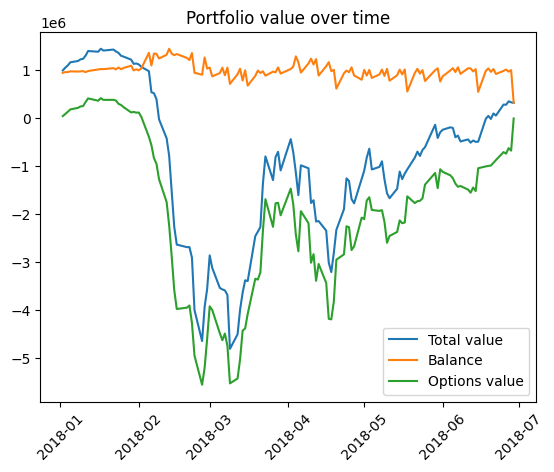

In [19]:
if run_optimizing == False:
    plot(df)

### Finding best thresholds

In [20]:
if run_optimizing:
    # Initialize wandb
    !pip install wandb
    import wandb
    wandb.login(key="b47bcf387a0571c5520c58a13be35cda8ada0a99")

    # Define the hyperparameters
    sweep_config = {
    'method': 'grid',
    'name': 'Latest pricing model - 1H18',
    'metric': {
        'goal': 'maximize', 
        'name': 'sharpe_ratio'
        },
    'parameters': {
        'buy_threshold': {
            'values': [1.1, 1.06, 1.04, 1.02]},
        'sell_threshold': {
            'values': [1.1, 1.06, 1.04, 1.02]},
        'starting_balance': {
            'values': [1000000]},
        'price_cap_lower': {
            'values': [5, 1, 0]},
        'ttm_cap_lower': {
            'values': [5, 1, 0]},
        }
    }
    sweep_id = wandb.sweep(sweep=sweep_config, project='options-trading') 


In [21]:
if run_optimizing:
    def find_best_thresholds(df = df):
        run = wandb.init(project = "options-trading")
        df = df.copy()
        buy_signal, sell_signal = generate_buy_sell_signals(df, run.config.buy_threshold, run.config.sell_threshold)
        df = trader(df, buy_signal, sell_signal, run.config.starting_balance, price_cap_lower = run.config.price_cap_lower, ttm_cap_lower = run.config.ttm_cap_lower)
        df = calculate_options_value(df)
        run.log({"buy_threshold": run.config.buy_threshold, "sell_threshold": run.config.sell_threshold, "sharpe_ratio": sharpe_ratio2(df), "starting_balance": run.config.starting_balance, "ending_balance": df['Balance'].iloc[-1], "number_of_trades": df['Signal'].abs().sum()})
        # Wandb callback
        print("buy_threshold", run.config.buy_threshold)
        print("sell_threshold", run.config.sell_threshold)
        print("starting_balance", run.config.starting_balance)
        print("Ending balance", df['Balance'].iloc[-1])
        print("Number of trades", df['Signal'].abs().sum())
        print("sharpe_ratio", sharpe_ratio(df))
        plot(df)
        run.finish()

    wandb.agent(sweep_id=sweep_id, function=find_best_thresholds, project='options-trading', count = 1000)